#**Preamble**

In [ ]:
!pip install scikit-plot

In [2]:
# import libraries
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#**Classification Task**

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


#(a) Brief Exploration:# 
Carry out a brief exploration of the dataset, such as the number of samples, the number of raw features, the fraction of missing values (if any), the number of categorical variables
(if any), histograms of different variables, etc. This exploration should be accompanied with detailed
commentary in markdown cells.

In [4]:
# statistics of the dataset
print(f'Shape of training samples: {X_train.shape}')
print(f'Shape of test samples: {X_test.shape}')
print(f'Number of classes: {len(np.unique(y_train))}')

Shape of training samples: (50000, 32, 32, 3)
Shape of test samples: (10000, 32, 32, 3)
Number of classes: 10


This dataset consists of image samples from 10 different classes -- *airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck* -- each label encoded with the first 10 natural numbers (0-9) respectively. The training dataset contains 50,000 images while the test dataset contains 10,000 images. All the samples are 32x32 RGB images <sup>[1]</sup>. 

In the code block below, we visualize some of the training samples along with their class labels as organized in the dataset.

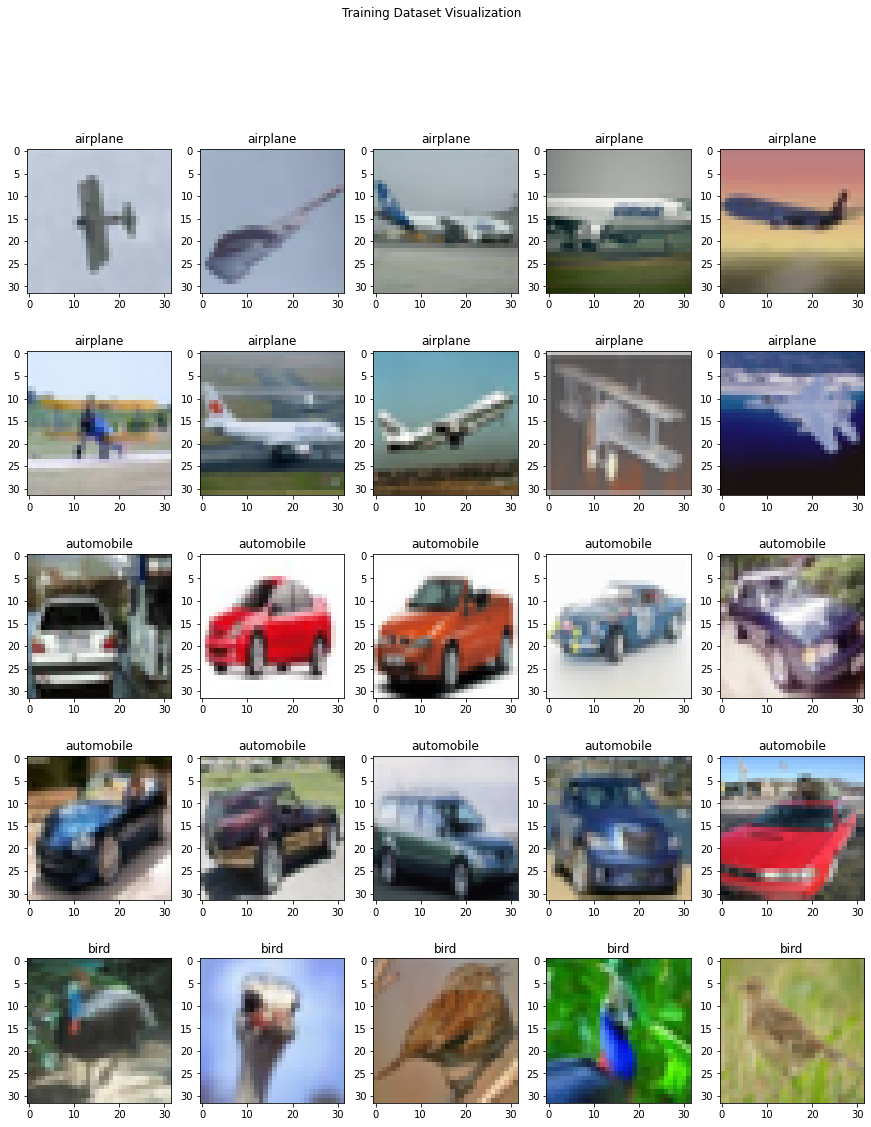

In [5]:
# visualizing training images
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels = np.unique(y_train)
final_list = []
name_list = []
labels = np.unique(y_train)
for label in labels: # specify the label of choice as filter condition
    label_list = list(np.where(y_train == label)[0]) # filter the labels by the condition, obtain the index numbers
    for iter in range(10): # get the 10 random index from the label list
        label_index = np.random.choice(tuple(label_list), replace=True)
        final_list.append(label_index)
        name_list.append(label_names[int(y_train[label_index])])
        
fig, ax = plt.subplots(5, 5, figsize=(15, 18))
fig.suptitle('Training Dataset Visualization')

k = 0
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(X_train[final_list[k]])
        ax[i][j].set_title(name_list[k])
        k += 1
        
plt.show();

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


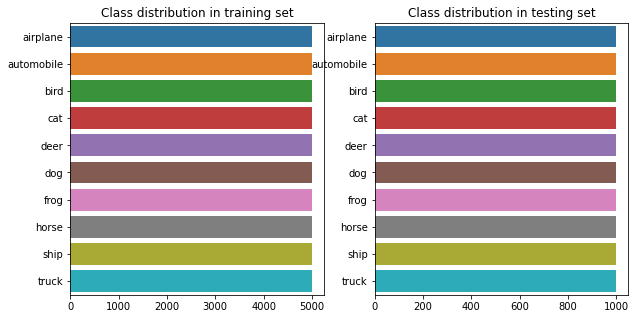

In [6]:
# distribution of samples in each class
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

classes_train, counts_train = np.unique(y_train, return_counts=True)
sns.barplot(counts_train, label_names, ax=axes[0]) 
axes[0].set_title('Class distribution in training set')

classes_test, counts_test = np.unique(y_test, return_counts=True)
sns.barplot(counts_test, label_names, ax=axes[1]) 
axes[1].set_title('Class distribution in testing set')

plt.show();

This bar plot shows the distribution of images per class in both training and testing datasets. We can see that each class in the dataset consists of an equal number of samples -- 5000/class for training images and 1000/class for test images <sup>[1]</sup>.

#(b) Pre-processing:# 
Carry out preprocessing of each dataset, which should be guided by your exploration of the dataset as well as your forthcoming plans for the datasets. This preprocessing could involve, e.g., replacement of invalid entries with plausible values, centering of the data, standardization of the data, encoding of categorical variables, etc. All of the preprocessing steps should be fully motivated and justified in markdown cells.

In [7]:
# Normalization
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

In pre-processing image data, normalization is an essential step. Here, normalization means making sure the pixels of all the images remain within a uniform range.

In [8]:
# Reshaping/Flattening
nsamples, nx, ny, nrgb = X_train_norm.shape
X_train_flat = X_train_norm.reshape((nsamples,nx*ny*nrgb))

nsamples, nx, ny, nrgb = X_test_norm.shape
X_test_flat = X_test_norm.reshape((nsamples,nx*ny*nrgb))

Reshaping is perhaps the most important pre-processing step for our image classification dataset. As we will be using sklearn to build our classifiers, we need to reshape the given images into a 2D array to fit the model. Currently, the raw images are in the form of 4D arrays *(num_samples, height, width, num_channels)*. We reshape all the images to be 2D -- *(num_samples, total_pixels = height X width X num_channels)*. Each image is therefore flattened from a 3D to a 1D numpy array. 

So, X_train: (50000, 32, 32, 3) --> (50000, 3072) and X_test: (10000, 32, 32, 3) --> (10000, 3072)

In general also, reshaping image data is very important to match input dimensions with the training images.

In [9]:
print(f'Shape of training samples: {X_train_flat.shape}')
print(f'Shape of test samples: {X_test_flat.shape}')

Shape of training samples: (50000, 3072)
Shape of test samples: (10000, 3072)


#(c) Feature Extraction / Feature Learning:#
Depending on the dataset, engage in either feature engineering or feature learning for that dataset. In the case of text dataset, e.g, this would involve transforming the raw text into numerical features. In the case of large images or correlated numerical variables, e.g., this could involve using something like principal component analysis (PCA) to reduce the dimensionality of images or to decorrelate different variables. All of the steps involved in this feature extraction / feature learning component should be fully motivated and justified in markdown cells.


In [10]:
from sklearn.decomposition import PCA

In [61]:
# concatenate training samples and labels into a dataframe for PCA
feature_cols = ['pixel' + str(i) for i in range(X_train_flat.shape[1])]
cifar10_df = pd.DataFrame(X_train_flat, columns = feature_cols)
cifar10_df['Class'] = y_train
print(f'Size of Data Frame: {cifar10_df.shape}') 

Size of Data Frame: (50000, 3073)


In [29]:
cifar10_df.shape

(50000, 3073)

In [ ]:
pca = PCA()
pca.fit(cifar10_df.iloc[:, :-1])

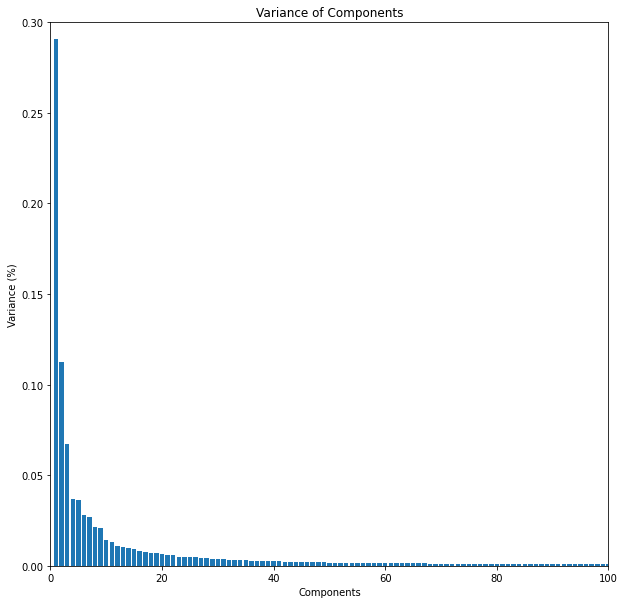

In [68]:
x = list(range(1, 3073)) 
plt.figure(figsize=(10, 10))
plt.bar(x, pca.explained_variance_ratio_)
plt.ylim(0, 0.3)
plt.xlim(0, 100)
plt.xlabel('Components')
plt.ylabel('Variance (%)')
plt.title('Variance of Components')
plt.show();

There is a variance drop off at number of components = 3, so the first three components explain the majority of the variance in our data.

In [69]:
# doing PCA on the dataset
pca_cifar = PCA(n_components = 3)
PC = pca_cifar.fit_transform(cifar10_df.iloc[:, :-1]) 

# convert principal components into dataframe
cifar_pca_df = pd.DataFrame(data = PC, columns = ['PC1', 'PC2', 'PC3'])
cifar_pca_df['Class'] = y_train
cifar_pca_df.shape

(50000, 4)

We use the built-in PCA feature from skicit-learn to compute the first three Principal Components of the training dataset. For consolidation, we compile the principal components and their corresponding labels into a pandas dataframe. We can now investigate the amount of information about variance that the principal components hold.

**Note:** In this code block, we manually enter how many principal components we want to compute by fixing the *n_components* parameter. However, another way to compute the PCA could be to specify total energy captured, in which case the number of PC would vary based on the nature of the dataset.

In [70]:
# variance of principal components
print(f'Explained Variation per Principal Component: {pca_cifar.explained_variance_ratio_}')

Explained Variation per Principal Component: [0.2907663  0.11253144 0.06694414]


It looks like a decent amount of information was retained by the first three principal components considering the data was projected from 3072 dimensions to only 3 principal components.

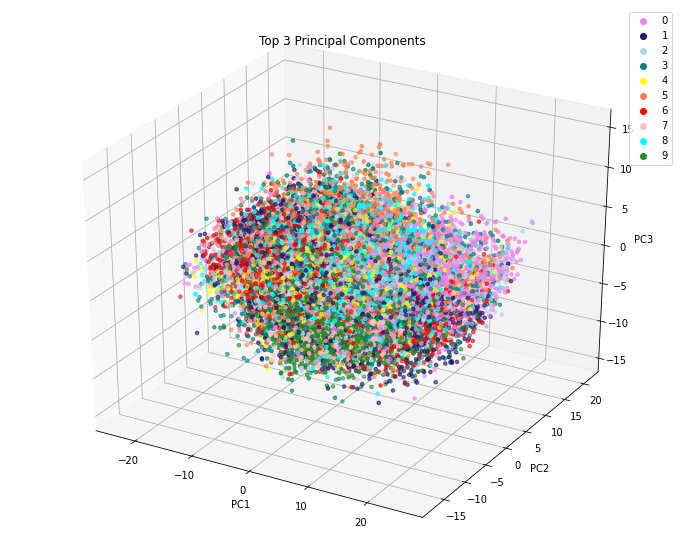

In [109]:
# visualizing the data in 3D space
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
colors = {0:'violet', 1:'midnightblue', 2:'lightblue', 3:'teal', 4:'yellow', 5:'coral', 6:'red', 7:'pink', 8:'cyan', 9:'forestgreen'}

x = cifar_pca_df["PC1"]
y = cifar_pca_df["PC2"]
z = cifar_pca_df["PC3"]

ax.scatter(x, y, z, c = cifar_pca_df['Class'].map(colors), marker='.', s = 50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Top 3 Principal Components')

markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)

plt.show();

From the above figure, we can observe that most of the variation is captured by the principal components, since there is some structure in the points when projected along the three PC axes. The data points (images) belonging to the same class are close to each other, and the images that are very different semantically are further away from each other.

**Note:** There is some semantic class overlap in CIFAR10. This means that a frog can have a slightly similar shape to a cat or a deer with a dog, especially when projected on to a 2D space. So, the differences between them might not be captured that well. 

The information obtained through this feature extraction method is useful for interpreting our classifiers in the following sections and eventually comparing the classifier <Sup>[6]<Sup>



#(d) Processing dataset using two different machine learning methods:#

Carry out the declared task on each dataset using two different machine learning methods, with the parameters for each method (where applicable) carefully tuned using cross-validation, the results averaged over multiple validation
folds, and the final results presented in an aesthetically pleasing manner. In addition, use markdown cells to justify different steps in your implementations and explain different aspects of the three methods as much as possible.

**1. K Nearest Neighbors** 

The first learning method we will use for our classifier is **K Nearest Neighbors** (kNN) by tuning the value of hyperparameter k using *cross-validation.* We leverage the built-in *KNeighborsClassifier* and *cross_val_score* APIs from scikit-learn in order to validate and train our model <sup>[2]</sup>.

In [110]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

**5-Fold Cross Validation**

In [116]:
# mean of 5-fold cross-validation on top 3 PC
k_range = range(1, 11)
k_scores = []

# iteratively caclulate different k, and return average accuracy based on the cross-validation score
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(knn, PC, y_train.ravel(), cv = 5, scoring = 'accuracy')
  k_scores.append(scores.mean())

print(max(k_scores)) 

0.20992000000000002


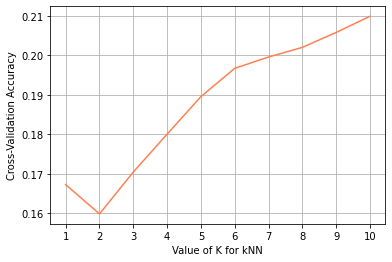

In [117]:
# plot the CV score trends for top 3 PC
plt.plot(k_range, k_scores, c='coral')
plt.xticks(k_range)
plt.xlabel('Value of K for kNN')
plt.ylabel('Cross-Validation Accuracy')
plt.grid()
plt.show();

The curve above shows that the cross-validation score occurs at **k = 10**. But as that is an even number, we would pick **k = 9**.

In [118]:
# we compute the mean of 5-fold cross-validation score for k ranging from 1 to 10 to see which gives best results
k_range = range(1, 11)
k_scores = []

# iteratively caclulate different k, and return average accuracy based on the cross-validation score
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(knn, X_train_flat, y_train.ravel(), cv = 5, scoring = 'accuracy')
  k_scores.append(scores.mean())

print(max(k_scores))

0.33836


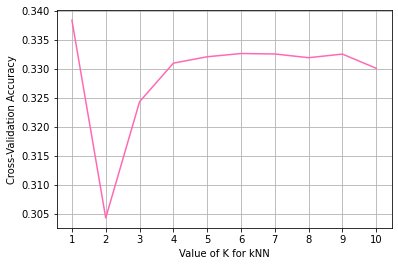

In [120]:
# plot the CV score trends for clarity 
plt.plot(k_range, k_scores, c='hotpink')
plt.xticks(k_range)
plt.xlabel('Value of K for kNN')
plt.ylabel('Cross-Validation Accuracy')
plt.grid()
plt.show();

The curve above shows that the cross-validation score occurs in the region where the values of k is between 6-9. We would pick **k = 7** as it is both an odd number (which is preferred for this learning method) and less computationally expensive.

We performed cross validation for the same range of k values on both top 3 principal components as well as on all raw features of the images. From the maximum cross validation scores obtained from both analyses, it is evident that all vectors score significantly higher. So, we will train our classifier on the raw features of the images with **k = 7** which is also less computationally expensive than k = 9.

In [121]:
# train best kNN model from cross-validation
knn_classifier = KNeighborsClassifier(n_neighbors = 7)
knn_classifier.fit(X_train_flat, y_train.ravel())

y_pred_knn = knn_classifier.predict(X_train_flat)
print(f'Training Accuracy = {accuracy_score(y_pred_knn, y_train)}')

Training Accuracy = 0.46422


In [122]:
# evaluation on test data
preds_knn = knn_classifier.predict(X_test_flat)

Test Accuracy = 0.3358
              precision    recall  f1-score   support

           0       0.52      0.40      0.45      1299
           1       0.20      0.70      0.30       280
           2       0.44      0.22      0.29      2013
           3       0.20      0.28      0.23       707
           4       0.52      0.23      0.32      2222
           5       0.20      0.40      0.27       504
           6       0.27      0.35      0.30       761
           7       0.20      0.70      0.31       281
           8       0.69      0.39      0.50      1749
           9       0.14      0.73      0.23       184

    accuracy                           0.34     10000
   macro avg       0.34      0.44      0.32     10000
weighted avg       0.45      0.34      0.35     10000



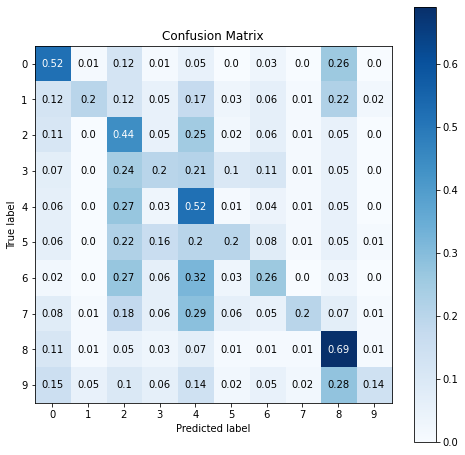

In [123]:
# evaluation metrics for test data
print(f'Test Accuracy = {accuracy_score(preds_knn, y_test)}')
print(classification_report(preds_knn, y_test))
# confusion_matrix(preds_knn, y_test)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test, preds_knn, normalize = True, title = "Confusion Matrix", cmap = "Blues", ax=ax);

The test accuracy for using a KNN classifier is only **33.58%**. This shows that the classifier is unable to accurately classify almost 70% of the images. 

From the classification table, it is evident that the most precise classification class is *ship* (69%) and the least precise is *truck*. The confusion matrix paints a similar picture. **The classifier seems to confuse truck with ship and airplane a lot**. Some other prominent confusion classes are:
* airplane and ship
* automobile and ship
* bird and deer
* cat and bird/deer
* dog and bird
* frog and bird/deer
* horse and deer

In summary, the classifier is weakest is classifying different transportation mediums and in differentiating deer and bird from other animals.

**2. Gaussian Naive Bayes**

We use **Gaussian Naive Bayes** (GNB) as the second learning method for our image classifier. We determine the parameters for the best performing model by doing **5-fold Cross Validation with Grid Search** on the training data first.

In [124]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

**Grid Search Cross Validation**

The tunable parameters for GNB, implemented using skicit-learn, are *priors* and *var_smoothing*. Priors are just the prior probabilities of the classes and var_smoothing is the portion of the largest variance of all features that is added to variances for calculation stability. For proper optimization of our classifier model we need to find the best combination of the two paraments. For this, we use **Grid Search Cross Validation with 5 folds** <Sup>[3][4]<Sup>

In [126]:
# 5-fold Grid Search Cross Validation to find the best model parameter (variance smoothing) for top 3 PC
params = {'priors': [None, [0.1,]* 10,], 'var_smoothing': np.logspace(0, -9, num = 10),}

grid_cv = GridSearchCV(GaussianNB(), param_grid = params, n_jobs=-1, cv=5, verbose=5)
grid_cv.fit(PC, y_train.ravel()) 

print(f"Best parameters: {grid_cv.best_params_}") 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'priors': None, 'var_smoothing': 0.001}


0.24572


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


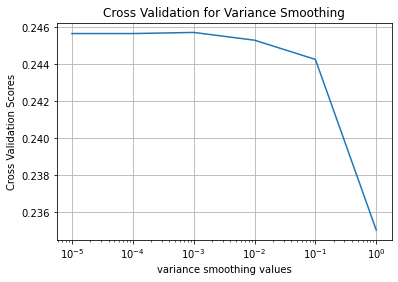

In [127]:
df = pd.DataFrame.from_dict(grid_cv.cv_results_) 
params_range = np.array(df['param_var_smoothing'][0:6])
cv_scores = np.array(df['mean_test_score'][0:6])
print(max(cv_scores))
x = np.logspace(0, -9, num = 10)

sns.lineplot(params_range, cv_scores)
plt.xscale('log')
plt.xlabel('variance smoothing values') 
plt.ylabel('Cross Validation Scores')
plt.title('Cross Validation for Variance Smoothing')
plt.grid()
plt.show();

In [128]:
# We use 5-fold Grid Search Cross Validation to find the best model parameter (variance smoothing)
params = {'priors': [None, [0.1,]* 10,], 'var_smoothing': np.logspace(0, -9, num = 10),}

grid_cv = GridSearchCV(GaussianNB(), param_grid = params, n_jobs=-1, cv=5, verbose=5)
grid_cv.fit(X_train_flat, y_train.ravel())

print(f"Best parameters: {grid_cv.best_params_}") 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'priors': None, 'var_smoothing': 1e-05}


0.28422000000000003


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


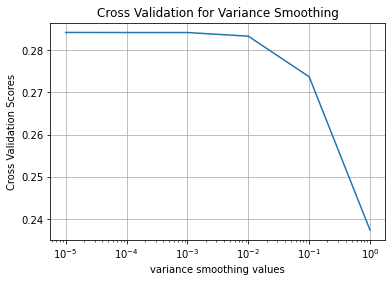

In [129]:
# plot cross vaidation results
df = pd.DataFrame.from_dict(grid_cv.cv_results_) 
params_range = np.array(df['param_var_smoothing'][0:6])
cv_scores = np.array(df['mean_test_score'][0:6])
print(max(cv_scores))
x = np.logspace(0, -9, num = 10)

sns.lineplot(params_range, cv_scores)
plt.xscale('log')
plt.xlabel('variance smoothing values') 
plt.ylabel('Cross Validation Scores')
plt.title('Cross Validation for Variance Smoothing')
plt.grid()
plt.show();

Gaussian Naive Bayes performs comparably on both raw features as well as top 3 Principal Components. So we train two classifiers on raw features and PC respectively and compare the testing accuracies.

In [130]:
# train best GNB model with raw training data
gnb_raw = GaussianNB(priors = None, var_smoothing = 1e-05)
gnb_raw.fit(X_train_flat, y_train.ravel())
y_pred_gnb_raw = gnb_raw.predict(X_train_flat)

print(f'Training Accuracy with raw images = {accuracy_score(y_pred_gnb_raw, y_train)}')

Training Accuracy with raw images = 0.28472


In [131]:
# train best GNB model with top 3 PC
gnb_pc = GaussianNB(priors = None, var_smoothing = 0.001) 
gnb_pc.fit(PC, y_train.ravel())
y_pred_gnb_pc = gnb_pc.predict(PC)

print(f'Training Accuracy with top 3 PC = {accuracy_score(y_pred_gnb_pc, y_train)}')

Training Accuracy with top 3 PC = 0.24674


Test Accuracy = 0.2976
              precision    recall  f1-score   support

           0       0.49      0.27      0.35      1817
           1       0.17      0.41      0.24       405
           2       0.08      0.19      0.12       443
           3       0.08      0.25      0.12       305
           4       0.42      0.24      0.30      1737
           5       0.26      0.31      0.29       840
           6       0.47      0.25      0.33      1846
           7       0.13      0.42      0.20       310
           8       0.47      0.39      0.42      1219
           9       0.41      0.38      0.39      1078

    accuracy                           0.30     10000
   macro avg       0.30      0.31      0.28     10000
weighted avg       0.39      0.30      0.32     10000



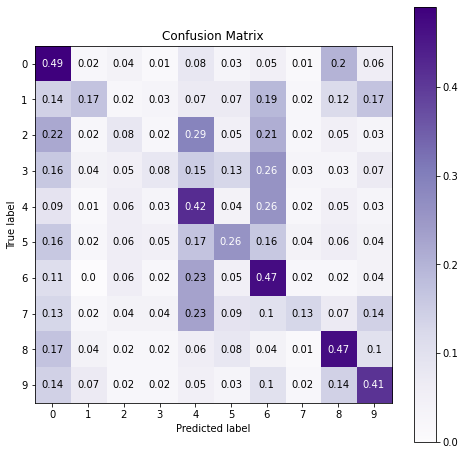

In [132]:
# evaluation on test data on classifier with raw features
preds_gnb_raw = gnb_raw.predict(X_test_flat)
print(f'Test Accuracy = {accuracy_score(preds_gnb_raw, y_test)}')
print(classification_report(preds_gnb_raw, y_test))
# confusion_matrix(preds_gnb, y_test) 

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test, preds_gnb_raw, normalize = True, title = "Confusion Matrix", cmap = "Purples", ax=ax);

Test Accuracy = 0.2516
              precision    recall  f1-score   support

           0       0.33      0.33      0.33      1008
           1       0.07      0.24      0.10       274
           2       0.12      0.18      0.14       642
           3       0.01      0.23      0.02        39
           4       0.33      0.19      0.24      1717
           5       0.26      0.25      0.25      1047
           6       0.34      0.22      0.27      1529
           7       0.14      0.19      0.16       732
           8       0.46      0.33      0.39      1395
           9       0.46      0.29      0.35      1617

    accuracy                           0.25     10000
   macro avg       0.25      0.24      0.23     10000
weighted avg       0.33      0.25      0.28     10000



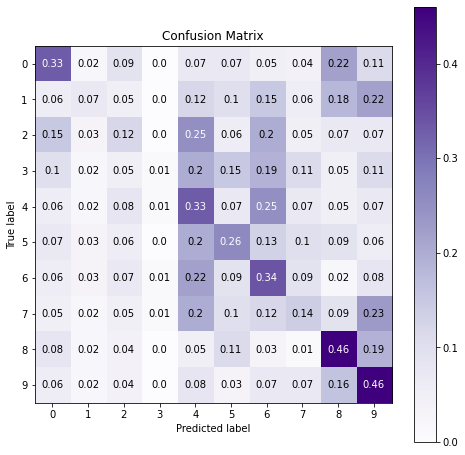

In [133]:
# evaluation on test data on classifier with top 3 PC
PC_test = pca_cifar.fit_transform(X_test_flat) 
preds_gnb_pc = gnb_pc.predict(PC_test)
print(f'Test Accuracy = {accuracy_score(preds_gnb_pc, y_test)}')
print(classification_report(preds_gnb_pc, y_test))
# confusion_matrix(preds_gnb, y_test) 

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test, preds_gnb_pc, normalize = True, title = "Confusion Matrix", cmap = "Purples", ax=ax);

The test accuracy for using a Naive Bayes classifier on raw features is about **30%** which is slightly better than the classifier trained on the top 3 Principal Components (**25.16%**). This shows that the classifier is unable to accurately classify over 70% of the images for both cases. But we further evaluate the classifier trained on raw features as that performs better.

From the classification table for *raw features*, it is evident that the most precise classification classes were *bird* and *cat* (8%) and the least precise is *truck*. The confusion matrix paints a similar picture. Some prominent confusion classes are:
* airplane and ship
* automobile and frog/truck
* bird and deer
* cat and frog
* deer and frog
* dog and deer
* horse and deer

In summary, the classifier is weak, but decent at classifying transportation mediums, but very bad at classifying animals. 

#(e) Comparative analysis of the two methods on dataset:# 

Provide a comparison between the two machine learning methods for each dataset across dimensions such as computational complexity,
performance, etc., and a final recommendation on the method that should go into production for each dataset. This comparison should include both coding cells (e.g., overlayed plots, side-by-side confusion matrices, etc.) and markdown cells for discussion.

We use two metrics to perform comparative analysis of the two learning methods/classifiers (using raw features for both):

1. F1-Score
2. Testing Accuracy

**F1-Score**

The F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. It is primarily used to compare the performance of two classifiers. F1-score ranges between 0 and 1. The higher the precision and recall, the higher the F1-score. Hence, ehe closer it is to 1, the better the model. A low F1 score is an indication of both poor precision and poor recall.

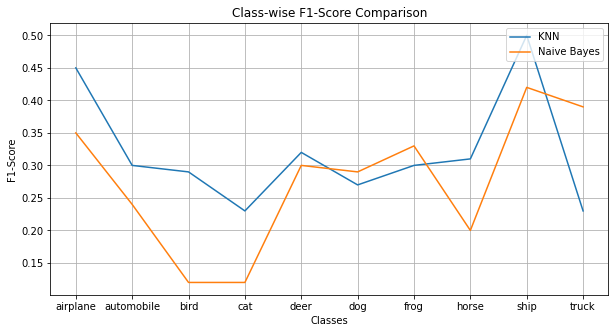

In [134]:
# comparing class-wise 
gnb_f1 = np.array([0.35, 0.24, 0.12, 0.12, 0.30, 0.29, 0.33, 0.20, 0.42, 0.39])
knn_f1 = np.array([0.45, 0.30, 0.29, 0.23, 0.32, 0.27, 0.30, 0.31, 0.50, 0.23])
# knn_f1.mean()
# gnb_f1.mean()

fig, ax = plt.subplots(figsize=(10, 5))
x = np.linspace(1, 10, num = 10)
ax.plot(x, knn_f1)
ax.plot(x, gnb_f1)
ax.legend(["KNN", "Naive Bayes"], loc ="upper right")

plt.xticks(x, label_names)
plt.xlabel("Classes")
plt.ylabel("F1-Score")
plt.title("Class-wise F1-Score Comparison")
plt.grid()
plt.show();

The class-wise F1-score of the two classifiers shows that KNN performs better than the Naive Bayes. The KNN F1-scores are consistently higher and closer to 1 than that of Naive Bayes -- only classes where Naive Bayes performs better are dog and frog. This trend implies that the KNN classifier has better overall precision and recall than the Naive Bayes classifier.

**Testing Accuracy**

This is a straightforward comparison metric. We use the model to predict the answers on the test dataset (held out data) and then compare the predicted target to the actual answer (ground truth) and take the mean of correct predictions made.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


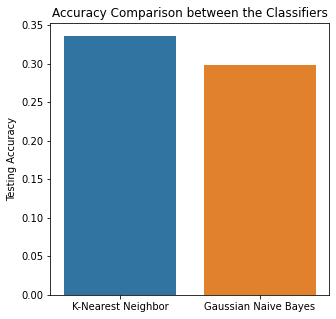

In [135]:
classifiers = np.array(['K-Nearest Neighbor', 'Gaussian Naive Bayes'])
scores = np.array([0.3358, 0.2976])

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(classifiers, scores)
plt.ylabel("Testing Accuracy")
plt.title("Accuracy Comparison between the Classifiers")
plt.show();

We can see that both classifiers have close testing accuracy scores. However, the K-Nearest Neighbor method achieves a higher accuracy of the same test data than Naive Bayes.

**Conclusion**: Based on the comparison shown above, *K Nearest Neighbor* (with k = 7) seems to perform better for image classification than Naive Bayes on CIFAR10 dataset. This could change for a different dataset and/or task however. 

**Additional Remarks**: From a broad overview, both the classifiers have quite low (sub-50) zero-shot classification accuracy scores. So, they wouldn't be good methods for image classification using CIFAR-10. Better algorithms for this task could perhaps be Decision Trees and Random Forest. However, the state-of-the-art method for image classification till now is Neural Networks, specifically Convolutional Neural Networks (CNN) and Vision Transformers (ViT). 

#(f) Discussion on ethical issues for dataset/task:# 
Provide a discussion on the ethical aspects of the machine learning tasks that you carried out on the declared datasets. This discussion should be carried out in a markdown cell and should be carefully formatted for readability purposes.

Ethics and bias are important aspects to consider in any Machine Learning task. But specifically in tasks like image classification which involves procuring images of subjects and labeling them, the matters of ethics and bias become more significant.

**Ethical Aspects for Image Classification:**
Two very important aspects to consider for any computer vision classification task are:

1. **Bias:** Image classification heavily involves curating image data to train the model. This data is collected from real world objects, including human beings, animals, locations, etc. In general, an ideal dataset would consist of images with a lot of variety with respect to the subject. For example, if the task is facial recognition, then it would be ideal for the dataset to consist of human faces from a wide range of demographics, gender identities, race and ethnicities, skin complexions, etc. If the dataset does not have this type of variety, the classifier will be abke to more accurately classify a specific demographic of people and fail to do so for another demographic. That is, the model would be *biased*. This is highly undesirable for classification models as these might result in wrongful categorizing of subjects resulting in dire consequences <Sup>[5]<Sup>. 

2. **Inaccuracy:** The task of image classification can be a very powerful tool in the fields of security, law enforcement, healthcare, etc. The degree of accuracy of the classification for these jobs is very important; in other words, inaccuracy becomes a very important metric for deployment of a classifier. For example, if image classification is used for disease detection and there are inaccuracies in the model, it might wrongfully classify the disease a patient is suffering from thus resulting in the physician selecting a completely wrong (and maybe even detrimental) course of treatment. Hence, inaccuracy and the degree of inaccuracy are very important ethical aspects to consider for image classification <Sup>[5]<Sup>.

**Ethical Aspects for Image Classification on CIFAR10:**
CIFAR-10 is a dataset of 60000 32x32 color images of 10 classes -- there are 50000 training images and 10000 test images. Some ethical considerations for this particular dataset used in image classification are:

The classes are completely mutually exclusive and there is no overlap between automobiles and trucks.

1. **Image Distribution in Each Class:** When training an image classifier, it is important to have an equal distribution of images in each class in the training dataset. Otherwise, the classifier may be **biased** to one class just because it had more training points than another class. In CIFAR10, there are 5000 images per class in the training dataset -- i.e. an equal distribution among classes.

2. **Image Variation in a Class:** The classes that are included in the CIFAR10 dataset are very common and frequently seen around us. So, the subjects can take various forms based on species, model, etc. but actually fall under the same class. So, it becomes important to make sure that the dataset is robust to transformation of each class subject. If this aspect is not kept under consideration, the model may be skewed in its ability to classify a test sample, showing more bias to a specific form or species of the subject in question.

#(g) Bibliography for each notebook:#
Provide bibliographic references that helped you during the preparation of the notebook. These references, which should be provided in a markdown cell at the end of the notebook, should be referenced within the body markdown cells of each notebook as much as possible.

1. Keras. “Keras Documentation: CIFAR10 Small Images Classification Dataset.” CIFAR10 Small Images Classification Dataset. Accessed 9 Dec. 2022. URL: https://keras.io/api/datasets/cifar10/ 

2. Sun, Qiping. “How to deal with Cross-Validation based on KNN algorithm, Compute AUC based on Naive Bayes algorithm” Medium, 18 May 2018. URL: https://medium.com/@svanillasun/how-to-deal-with-cross-validation-based-on-knn-algorithm-compute-auc-based-on-naive-bayes-ff4b8284cff4 

3. “Scikit-Learn - Naive Bayes Classifiers by Sunny Solanki.” Scikit-Learn - Naive Bayes Classifiers. Accessed 9 Dec. 2022. 
URL: https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-naive-bayes#4 

4. Shah, Rahul. “GridSearchCV |Tune Hyperparameters With GridSearchCV.” Analytics Vidhya, 23 June 2021. 
URL: https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/

5. “Ethical Issues in Computer Vision and Strategies for Success — Innodata.” Innodata Inc., 9 Nov. 2021. URL: https://innodata.com/ethical-issues-in-computer-vision-and-strategies-for-success/ 

6. “PCA Application Using CIFAR10 Dataset.” PCA Application Using CIFAR10 Dataset | Kaggle. Accessed 9 Dec. 2022. URL: https://www.kaggle.com/code/adtysregita/pca-application-using-cifar10-dataset 

